In [82]:
# !pip install plotly
import pandas as pd
# !pip install pandas_ta
import pandas_ta as ta
import numpy as np
import datetime
from datetime import timedelta
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# import chart_studio.tools as tls

I need a 3 indicator signaling trading bot for Binance API, its fairly complicated, and there are challenging parts but I have enough experience building up bots for Binance with freelancers so It should take, with the right expert, around 2-3 weeks for the project

Indicators: RSI , VWAP and EMA in 2 different time frames

# built 60 day historic prices dataframe for a given a list of coins

# Calculating RSI Manually

In [51]:
#clean version of historic prices and volume request
#timestamps are in day-month-year
import requests
import datetime
import pandas as pd
from datetime import timedelta



#manipulatable variables
numDaysBack = str(365) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum', 'bitcoin', 'solana']
window_length = 14

#builds initial dataframe with ethereum as first market but just to log the dates
geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
r = requests.get(geckoReq).json()
ts = r['prices'][0][0]
ts = ts/1000
HistPricesList = []
for i in range(len(r['prices'])):
    currentUnix = r['prices'][i][0] 
    price = r['prices'][i][1]
    currentUnix = currentUnix/1000
    currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S")
    HistPricesList.append([currentTS])
global dfPrices
dfPrices = pd.DataFrame(HistPricesList, columns = ['dates'])
print(dfPrices)



#appends the other coins in the coinlist to the dataframe
def historicalCoinData(coin):
    global dfPrices
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%d-%m-%Y %H:%M:%S"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['dates', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    dfPrices = pd.merge(dfPrices, dfCoin[coin], left_on = dfPrices['dates'], right_on=dfCoin['dates']).drop(['key_0'], axis = 1)
    dfPrices = pd.merge(dfPrices, dfCoin[coin+'_volume'], left_on = dfPrices['dates'], right_on=dfCoin['dates']).drop(['key_0'], axis = 1)
    # display(dfPrices)
    
    #adding some calculated numbers 
    dfPrices[coin+'_ewm'] = dfPrices[coin].ewm(com=0.4).mean()
    dfPrices['diff'] = dfPrices[coin].diff(1)
    dfPrices['gain'] = dfPrices['diff'].clip(lower=0).round(2)
    dfPrices['loss'] = dfPrices['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    dfPrices['avg_gain'] = dfPrices['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    dfPrices['avg_loss'] = dfPrices['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(dfPrices['avg_gain'].iloc[window_length+1:]):
        dfPrices['avg_gain'].iloc[i + window_length + 1] =\
            (dfPrices['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             dfPrices['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(dfPrices['avg_loss'].iloc[window_length+1:]):
        dfPrices['avg_loss'].iloc[i + window_length + 1] =\
            (dfPrices['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             dfPrices['loss'].iloc[i + window_length + 1])\
            / window_length
        
    dfPrices['rs'] = dfPrices['avg_gain'] / dfPrices['avg_loss']
    
    dfPrices['rsi'] = 100 - (100 / (1.0 + dfPrices['rs']))
    dfPrices = pd.DataFrame(dfPrices)
    dfPrices = dfPrices.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    dfPrices.rename(columns=dict,
              inplace=True)
    return dfPrices

# historicalCoinData('ethereum')
for i in theCoins:
    historicalCoinData(i)
    print('just added: ', i)

display(dfPrices[window_length-1:window_length+5])



                   dates
0    29-06-2021 18:00:00
1    30-06-2021 18:00:00
2    01-07-2021 18:00:00
3    02-07-2021 18:00:00
4    03-07-2021 18:00:00
..                   ...
361  25-06-2022 18:00:00
362  26-06-2022 18:00:00
363  27-06-2022 18:00:00
364  28-06-2022 18:00:00
365  28-06-2022 23:47:40

[366 rows x 1 columns]
29-06-2021 18:00:00
just added:  ethereum


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


29-06-2021 18:00:00
just added:  bitcoin
29-06-2021 18:00:00
just added:  solana


,dates,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,bitcoin,bitcoin_volume,bitcoin_ewm,bitcoin_diff,bitcoin_rsi,solana,solana_volume,solana_ewm,solana_diff,solana_rsi
13,12-07-2021 18:00:00,2042.499187,1.640390e+10,2070.726339,-101.515071,NaN,33262.654352,2.168389e+10,33511.763042,-1037.283664,NaN,30.953474,3.123303e+08,31.314281,-1.169818,NaN
14,13-07-2021 18:00:00,1944.395017,1.821092e+10,1980.489679,-98.104170,40.371762,32676.383801,1.993253e+10,32915.063580,-586.270551,34.224491,29.162068,2.703924e+08,29.776986,-1.791406,36.689038
15,14-07-2021 18:00:00,1997.663314,2.000744e+10,1992.756561,53.268297,43.162244,32878.501874,2.177907e+10,32888.948075,202.118073,35.568384,31.236001,4.744546e+08,30.819140,2.073933,43.707444
16,15-07-2021 18:00:00,1910.726952,1.797820e+10,1934.163983,-86.936362,39.881863,31726.038834,2.155773e+10,32058.298617,-1152.463040,31.603448,28.323537,4.690484e+08,29.036567,-2.912464,37.426238
17,16-07-2021 18:00:00,1874.200250,1.744840e+10,1891.332745,-36.526702,38.555916,31399.653129,2.267186e+10,31587.837554,-326.385705,30.564289,26.263233,3.721199e+08,27.055614,-2.060305,33.730744
18,17-07-2021 18:00:00,1899.842750,1.492035e+10,1897.411320,25.642500,40.062192,31588.671351,1.771546e+10,31588.433123,189.018222,31.959597,26.791688,2.926464e+08,26.867095,0.528455,35.495480


# splitting all calculations into their own functions

In [77]:
#manipulatable variables
numDaysBack = str(365) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins, window, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins
    window_length = window

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
        add_ewm(coin, mycom)
        add_rsi(coin, window_length)
        add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    
    df = df.set_index('date')
    
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    print('hey macd')
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()
    print('k', k)
    print('d', d)
    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = df_builder_clean(numDaysBack, myInterval, theCoins, window_length, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
display(mydf)

06-30-2021
hey macd
k 0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
          ...     
367    1149.582378
368    1141.785938
369    1135.188950
370    1128.593419
371    1123.012584
Name: ethereum, Length: 372, dtype: float64
d 0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
          ...     
367    1293.309930
368    1278.909603
369    1265.575967
370    1252.742043
371    1240.858781
Name: ethereum, Length: 372, dtype: float64
just added:  ethereum


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
date,,,,,,,,
06-30-2021,2279.354161,2.904622e+10,2279.354161,NaN,NaN,NaN,NaN,NaN
07-01-2021,2121.657901,2.587425e+10,2156.701514,-157.696261,NaN,NaN,NaN,NaN
07-02-2021,2157.880585,2.286922e+10,2157.563820,36.222684,NaN,NaN,NaN,NaN
07-03-2021,2228.532399,1.995430e+10,2208.595733,70.651814,NaN,NaN,NaN,NaN
07-04-2021,2329.004751,2.111921e+10,2294.766240,100.472352,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
06-29-2022,1092.317995,1.470745e+10,1093.258163,0.000000,33.270650,-143.727552,25.814376,-169.541928
06-29-2022,1098.905518,1.475544e+10,1097.291988,6.587523,33.954425,-137.123665,25.934610,-163.058276
06-29-2022,1098.905518,1.470745e+10,1098.444509,0.000000,33.954425,-130.387017,26.137007,-156.524024


In [92]:
# Force lowercase (optional)
df.columns = [x.lower() for x in df.columns]
# Construct a 2 x 1 Plotly figure
fig = make_subplots(rows=2, cols=1)
# price Line
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df[df.columns[0]].values,
        line=dict(color='#ff9900', width=1),
        name=df.columns[0],
        # showlegend=False,
        legendgroup='1',
    ), row=1, col=1
)
# Candlestick chart for pricing
fig.append_trace(
    go.Candlestick(
        x=df.index,
        open=df[df.columns[0]].values,
        high=df[df.columns[0]].values,
        low=df[df.columns[0]].values,
        close=df[df.columns[0]].values,
        increasing_line_color='#ff9900',
        decreasing_line_color='black',
        showlegend=False
    ), row=1, col=1
)
# Fast Signal (%k)
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['macd'],
        line=dict(color='#ff9900', width=2),
        name='macd',
        # showlegend=False,
        legendgroup='2',
    ), row=2, col=1
)
# Slow signal (%d)
fig.append_trace(
    go.Scatter(
        x=df.index,
        y=df['macd_s'],
        line=dict(color='#000000', width=2),
        # showlegend=False,
        legendgroup='2',
        name='signal'
    ), row=2, col=1
)
# Colorize the histogram values
colors = np.where(df['macd_h'] < 0, '#000', '#ff9900')
# Plot the histogram
fig.append_trace(
    go.Bar(
        x=df.index,
        y=df['macd_h'],
        name='histogram',
        marker_color=colors,
    ), row=2, col=1
)
# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        )
    )
)
# Update options and show plot
fig.update_layout(layout)
fig.show()

In [90]:
# dfPrices = dfPrices.dropna().set_index('dates')
# display(dfPrices.head(17))
df[df.columns[0]].values

array([2279.35416142, 2121.65790063, 2157.88058487, 2228.53239857,
       2329.004751  , 2217.30185306, 2320.65492883, 2317.2369427 ,
       2126.44246739, 2156.58095695, 2123.05859749, 2144.01425727,
       2042.49918661, 1944.39501664, 1997.66331367, 1910.72695163,
       1874.20024968, 1899.84275007, 1905.72338284, 1824.92939209,
       1794.97342519, 2003.72392145, 2027.53344792, 2117.15460779,
       2183.62741456, 2209.4993601 , 2230.21206767, 2292.5796368 ,
       2299.68940594, 2383.44325996, 2462.39998265, 2541.67459937,
       2555.40817851, 2611.67306995, 2521.26847489, 2724.53224271,
       2821.64969275, 2888.73227428, 3151.21751692, 3012.30855927,
       3163.06465519, 3147.8429954 , 3166.64721797, 3048.41268169,
       3323.19799054, 3268.54817703, 3309.75491041, 3153.58368376,
       3007.14402717, 3037.2302512 , 3144.81843679, 3276.96983664,
       3224.00046015, 3243.48635835, 3320.40916978, 3177.6637963 ,
       3231.44145173, 3122.97179724, 3267.53943475, 3245.43022

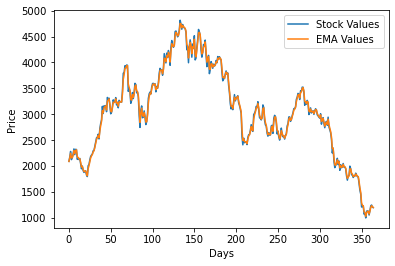

just added:  polkadot
just added:  polkadot
just added:  polkadot
just added:  polkadot
just added:  polkadot
just added:  polkadot
just added:  polkadot
just added:  polkadot
                   dates     ethereum  ethereum_volume       bitcoin  \
0    28-06-2021 18:00:00  2087.518724     3.062933e+10  34556.842127   
1    29-06-2021 18:00:00  2169.400068     2.714914e+10  35968.993668   
2    30-06-2021 18:00:00  2279.354161     2.904622e+10  35171.486305   
3    01-07-2021 18:00:00  2121.657901     2.587425e+10  33677.566236   
4    02-07-2021 18:00:00  2157.880585     2.286922e+10  33950.786555   
..                   ...          ...              ...           ...   
360  23-06-2022 18:00:00  1144.480753     1.424795e+10  21100.270534   
361  24-06-2022 18:00:00  1229.304085     1.628849e+10  21262.713483   
362  25-06-2022 18:00:00  1244.286204     1.169272e+10  21525.880362   
363  26-06-2022 18:00:00  1201.237791     1.137575e+10  21052.805398   
364  27-06-2022 18:00:00  1194.2

In [14]:

# plt.plot(dfPrices['ethereum'], label="Stock Values")
# plt.plot(dfPrices['ethereum_ewm'], label="EMA Values")
# plt.xlabel("Days")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

for coin in theCoins:
    dfPrices[coin+'_ewm'] = dfPrices[coin].ewm(com=0.4).mean()
    print('just added: ', coin)
    
print(dfPrices)